In [2]:
PATH = '.'
PATH_DATA = PATH + r'/data/'
PATH_RUBERT = PATH + r'/ru_bert_tf'
PATH_RESULTS = PATH + r'/modelResults'
train_file = r'train_2020_04+.csv'
valid_file = r'validate_2020_04+.csv'
test_file = r'test_2020_04+.csv'
train_file_tr = r'train_2020_04+_tr.csv'
valid_file_tr = r'validate_2020_04+_tr.csv'
test_file_tr = r'test_2020_04+_tr.csv'

In [3]:
import tensorflow as tf

tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [9]:
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor
from deeppavlov.models.preprocessors.one_hotter import OneHotter
from deeppavlov.models.bert.bert_classifier import BertClassifierModel

from deeppavlov.metrics.roc_auc_score import roc_auc_score
from deeppavlov.metrics.fmeasure import round_f1_weighted
from deeppavlov.metrics.accuracy import sets_accuracy

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, \
    roc_auc_score, roc_curve, multilabel_confusion_matrix, confusion_matrix

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time
import re
import ast

from tqdm import tqdm_notebook

import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
df_train = pd.read_csv(PATH_DATA + train_file_tr)
df_train.sample(10)

,comment,topicsRaw,topics
70937,"Курить вредно, а сервис хороший",['Staff reliability'],Staff reliability
27547,"Быстро, комфортно. Качество и удобство",['Uncategorized'],Uncategorized
22045,Лучшее что есть10,['Uncategorized'],Uncategorized
76310,Не хочу быть промоутером8,['Uncategorized'],Uncategorized
608,Нравится,['Uncategorized'],Uncategorized
7634,"Очень приятный коллектив, всегда вежливо общаю...","['Friendliness', 'Staff reliability']",Friendliness;Staff reliability
39225,Мне очень понравилось курить IQOS,['Uncategorized'],Uncategorized
66385,Порекомкндую полностью бросить,['Uncategorized'],Uncategorized
70661,Заебись...!,['Uncategorized'],Uncategorized
79484,"Отличный сервис по гарантии, быстро и без проблем","['Return/ replacement process', 'Staff reliabi...",Return/ replacement process;Staff reliability


In [7]:
del df_train

In [10]:
modelLoad = r'/model_020321'
modelSave = r'/model_020321Topics'
PATH_LOAD = None
PATH_SAVE = None

if modelLoad is not None:
    PATH_LOAD = PATH_RESULTS + modelLoad
    classes = np.load(PATH_LOAD + r'/classes.npy', allow_pickle=True)
if modelSave is not None:
    if not os.path.exists(PATH_RESULTS + modelSave):
        os.mkdir(PATH_RESULTS + modelSave)
    PATH_SAVE = PATH_RESULTS + modelSave    

reader = BasicClassificationDatasetReader()
data = reader.read(
    data_path = PATH_DATA, train = train_file_tr, valid = valid_file_tr,
    test = test_file_tr, class_sep =';', x = 'comment', y = 'topics'
)

iterator = BasicClassificationDatasetIterator(data, shuffle = True)

if modelLoad is not None: mlb = MultiLabelBinarizer(classes = classes)
else: mlb = MultiLabelBinarizer()                      
mlb.fit_transform(iterator.get_instances('train')[1])

if modelSave is not None:
    np.save(PATH_SAVE + r'/classes.npy', mlb.classes_)

bert_preprocessor = BertPreprocessor(
    vocab_file=PATH_LOAD + r'/vocab.txt',
    do_lower_case=False,
    max_seq_length=64
)

bert_classifier = BertClassifierModel(
    n_classes = len(mlb.classes_),
    return_probas = True,
    one_hot_labels = True,
    bert_config_file = PATH_RUBERT + r'/bert_config.json',
    pretrained_bert = r'bert_model.ckpt',
    save_path = PATH_SAVE + r'/model',
    load_path = PATH_LOAD + r'/model',
    keep_prob = 0.5,
    learning_rate = 1e-05,
    min_learning_rate = 1e-07,
    learning_rate_drop_patience = 5,
    learning_rate_drop_div = 2.0,
    multilabel = True
)
bert_classifier.load()

2021-03-03 05:02:24.570 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 45: Load path '/home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model' differs from save path '/home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321Topics/model' in 'infer' mode for BertClassifierModel.








The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-03-03 05:02:40.757 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]



INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model


2021-03-03 05:02:42.131 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model


In [79]:
def calculate_metrics(y_true, predictions, num_classes, micro = False, ts = None):
    if ts is None:
        y_pred = (predictions>0.5).astype(int)
    else:
        y_pred = (predictions>ts).astype(int)
        
    check =  ((y_pred.sum(axis=0) > 0).sum() == y_pred.shape[1]) | ((y_pred.sum(axis=0) > 0).sum() == 0)
    acc_total = 0.0 if check else \
        accuracy_score(y_true[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)], 
                       y_pred[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)])
    hamm_loss = hamming_loss(y_true, y_pred)
    f1_score_total = f1_score(y_true[:, y_true.sum(axis=0) > 0], 
                              y_pred[:, y_true.sum(axis=0) > 0], 
                              average='weighted')
    roc_auc_total = roc_auc_score(y_true[:, y_true.sum(axis=0) > 0],
                                  predictions[:, y_true.sum(axis=0) > 0], 
                                  average='weighted')

    
    acc_classes = None
    f1_scores_classes = None
    roc_auc_classes = None

    if micro:
        acc_classes = []
        f1_scores_classes = []
        roc_auc_classes = []

        for i in range(num_classes):
            acc_class = accuracy_score(y_true[:, i], y_pred[:, i])
            acc_classes.append(acc_class)
            f1_score_class = np.NAN if y_true[:, i].sum() == 0 else\
                f1_score(y_true[:, i], y_pred[:, i], average='macro')
            f1_scores_classes.append(f1_score_class)
            roc_auc_class = np.NAN if y_true[:, i].sum() == 0 else\
                roc_auc_score(y_true[:, i], predictions[:, i], average='macro')
            roc_auc_classes.append(roc_auc_class)
    
    return acc_total, acc_classes, hamm_loss, f1_score_total, f1_scores_classes, roc_auc_total, roc_auc_classes

def optimal_threshold(y_true, predictions, num_classes, verbose = False):
    thresholds = np.linspace(0,1,10000)
    
    # False negative rate
    fnr = np.zeros((num_classes, 10000))
    
    # False discovery rate
    fdr = np.zeros((num_classes, 10000))
    
    if verbose:
        print('Calculating optimal threshold')
        for i, threshold in enumerate(tqdm_notebook(thresholds)):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)
            fnr[tp == 0, i] = np.nan
            fdr[tp == 0, i] = np.nan
    else:
        for i, threshold in enumerate(thresholds):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)
            fnr[tp == 0, i] = np.nan
            fdr[tp == 0, i] = np.nan

    return thresholds[np.abs(fnr-fdr).argsort(axis=1)[:, 0]]

def get_preds(data_type, topicsInd = None, verbose = False):
    y_preds = []
    
    data = iterator.get_instances(data_type)
    x = np.array(data[0])
    y = mlb.transform(data[1])
    
    if topicsInd is not None:
        tar_ind = np.argwhere(y[:, topicsInd].sum(axis=1) > 0)[:, 0]
        nottar_ind = np.argwhere(y[:, topicsInd].sum(axis=1) == 0)[:, 0]
        nottar_ind = np.random.choice(nottar_ind, tar_ind.shape[0], replace = False)
        res_ind = np.concatenate([tar_ind, nottar_ind])
        np.random.shuffle(res_ind)
        x = x[res_ind]
        y = y[res_ind]
    
    if verbose:
        print(f'Predicting {data_type} data')
        for i in tqdm_notebook(range(0, len(x), 256)):
            x_b = x[i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x_b))
            y_preds.append(y_pred)
    else:
        for i in range(0, len(data[0]), 256):
            x_b = x[i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x_b))
            y_preds.append(y_pred)
        
    y_preds = np.concatenate(y_preds, axis=0)
    
    return  y, y_preds

In [45]:
def print_classes_metrics(train_acc_class, train_f1_score_class, train_roc_auc_class, y_train, 
                          valid_acc_class, valid_f1_score_class, valid_roc_auc_class, y_valid,
                          test_acc_class, test_f1_score_class, test_roc_auc_class, y_test,
                          classes):
    print(f'{"Class":>50} {"Accuracy":>26} {"F1 score":>15} {"ROC-AUC":>15} {"Size":>15}')
    for i, c in enumerate(classes):
        print(f'{c:>50} Train      {train_acc_class[i]:>15.6f} {train_f1_score_class[i]:>15.6f} {train_roc_auc_class[i]:>15.6f} {y_train[:, i].sum():>15d}')
        print(f'{" ":>50} Validation {valid_acc_class[i]:>15.6f} {valid_f1_score_class[i]:>15.6f} {valid_roc_auc_class[i]:>15.6f} {y_valid[:, i].sum():>15d}')
        print(f'{" ":>50} Test       {test_acc_class[i]:>15.6f} {test_f1_score_class[i]:>15.6f} {test_roc_auc_class[i]:>15.6f} {y_test[:, i].sum():>15d}')

def plot_cm(y_true, predictions, classes, ts = None):
    if ts is None:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > 0.5).astype(int))
    else:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > ts).astype(int))

    fig, axes = plt.subplots(len(classes)//4 + 1, 4, figsize=(20, ((len(classes)+3)//4)*5))
    for axes, cm, label in zip(axes.flatten(), cms, classes):
        df_cm = pd.DataFrame(cm, 
                             index=[0, 1], 
                             columns=[0, 1])
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes,  annot_kws={"fontsize":20})
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=15)
        axes.set_xlabel('Predicted label', fontsize=20)
        axes.set_ylabel('True label', fontsize=20)
        axes.set_title(label, fontsize=15)
        
    fig.tight_layout()
    plt.show()  

def plot_cm_class(y_true, predictions, class_name, ts = None):
    if ts is None:
        cm = confusion_matrix(y_true, (predictions > 0.5).astype(int))
    else:
        cm = confusion_matrix(y_true, (predictions > ts).astype(int))

    sns.heatmap(cm, annot=True, fmt='d', cbar=False, annot_kws={"fontsize":20})
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.tick_params(labelsize=20)
    plt.title(class_name, fontsize = 15)
    plt.show()

Predicting train data



Predicting valid data



Predicting test data



Train:        Accuracy: 0.87801, F1 score: 0.93081, Hamming Loss: 0.00384, ROC-AUC: 0.99592
Validation:   Accuracy: 0.70998, F1 score: 0.82093, Hamming Loss: 0.01028, ROC-AUC: 0.97029
Test:         Accuracy: 0.69488, F1 score: 0.81186, Hamming Loss: 0.01080, ROC-AUC: 0.96752


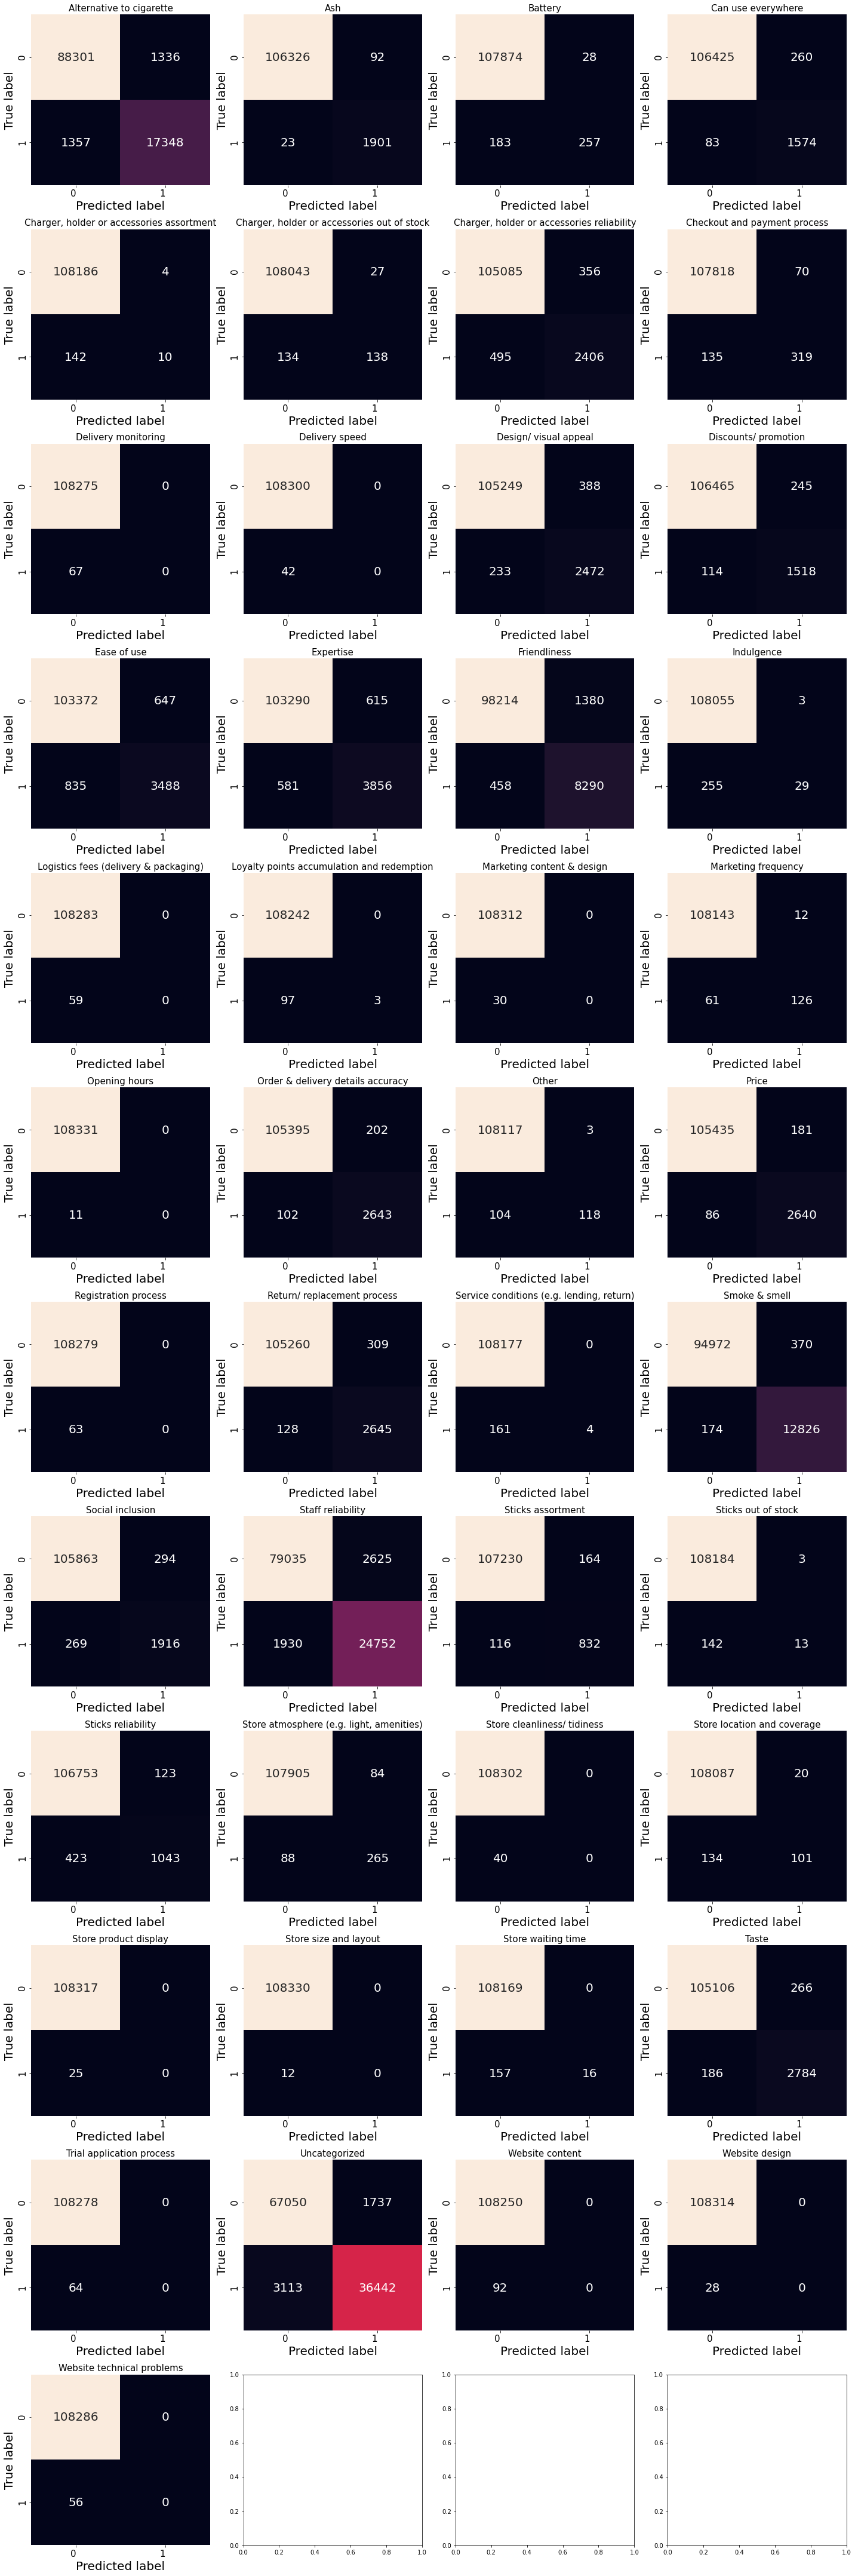

In [16]:
y_train, y_train_preds = get_preds('train', verbose = True)
y_valid, y_valid_preds = get_preds('valid', verbose = True)
y_test, y_test_preds = get_preds('test', verbose = True)

train_acc, train_acc_class, train_hamm, train_f1_score, train_f1_score_class, train_roc_auc, train_roc_auc_class = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True)

valid_acc, valid_acc_class, valid_hamm, valid_f1_score, valid_f1_score_class, valid_roc_auc, valid_roc_auc_class = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True)

test_acc, test_acc_class, test_hamm, test_f1_score, test_f1_score_class, test_roc_auc, test_roc_auc_class = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc, train_f1_score, train_hamm, train_roc_auc))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc, valid_f1_score, valid_hamm, valid_roc_auc))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc, test_f1_score, test_hamm, test_roc_auc))

plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_)

In [37]:
def print_classes_error_rate(y_true, predictions, classes, topics = None, ts = None, threshold = None):
    if ts is None:
        y_pred = (predictions>0.5).astype(int)
    else:
        y_pred = (predictions>ts).astype(int)
    
    if topics is not None:
        classes_ind = np.argwhere(np.isin(classes, topics))[:, 0]
    else:
        classes_ind = np.arange(classes.shape[0])
    
    for i in classes_ind:
        p = (y_true[:, i] == 1).sum()
        tp = y_pred[:, i][y_true[:, i] == 1].sum()
        fp = y_pred[:, i][y_true[:, i] == 0].sum()
        fn = (y_pred[:, i] == 0).astype(int)[y_true[:, i] == 1].sum()
        er = tp/(fp+fn)
        if threshold is not None and er < threshold:
            print(f'{classes[i]:>50}   Error rate:{er:>10.6f}  TP:{tp:>5d}  FP:{fp:>5d}  FN:{fn:>5d}  P:{p:>5d}')
        if threshold is None:
            print(f'{classes[i]:>50}   Error rate:{er:>10.6f}  TP:{tp:>5d}  FP:{fp:>5d}  FN:{fn:>5d}  P:{p:>5d}')


print_classes_error_rate(
    np.concatenate([y_train, y_valid, y_test]), 
    np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
    mlb.classes_,
    threshold = 0.8
)

         Charger, holder or accessories assortment   Error rate:  0.068493  TP:   10  FP:    4  FN:  142  P:  152
                               Delivery monitoring   Error rate:  0.000000  TP:    0  FP:    0  FN:   67  P:   67
                                    Delivery speed   Error rate:  0.000000  TP:    0  FP:    0  FN:   42  P:   42
                                        Indulgence   Error rate:  0.112403  TP:   29  FP:    3  FN:  255  P:  284
             Logistics fees (delivery & packaging)   Error rate:  0.000000  TP:    0  FP:    0  FN:   59  P:   59
        Loyalty points accumulation and redemption   Error rate:  0.030928  TP:    3  FP:    0  FN:   97  P:  100
                        Marketing content & design   Error rate:  0.000000  TP:    0  FP:    0  FN:   30  P:   30
                                     Opening hours   Error rate:  0.000000  TP:    0  FP:    0  FN:   11  P:   11
                              Registration process   Error rate:  0.000000  TP:    0  FP

In [38]:
def get_data_topics(data_instance, classes, topics = None, auto = False, preds = None, ts = None, threshold = None):
    x = np.array(data_instance[0])
    y = mlb.transform(data_instance[1])
    
    if ts is None: y_pred = (preds>0.5).astype(int)
    else: y_pred = (preds>ts).astype(int)
    
    if threshold is None: threshold = 1
        

    if auto:
        p = (y == 1).sum(axis = 0)
        tp = (y_pred & (y == 1)).sum(axis = 0)
        fp = (y_pred & (y == 0)).sum(axis = 0)
        fn = ((y_pred == 0) & (y == 1)).sum(axis = 0)
        res = tp/(fp+fn)
        topics_ind = np.argwhere(res <= threshold)[:, 0]
    else:
        if topics is not None:
            topics_ind = np.argwhere(np.isin(classes, topics))[:, 0]
        else:
            topics_ind = np.arange(classes.shape[0])
        
    tar_ind = np.argwhere(y[:, topics_ind].sum(axis=1) > 0)[:, 0]
    nottar_ind = np.argwhere(y[:, topics_ind].sum(axis=1) == 0)[:, 0]
    nottar_ind = np.random.choice(nottar_ind, tar_ind.shape[0], replace = False)
    res_ind = np.concatenate([tar_ind, nottar_ind])
    np.random.shuffle(res_ind)
    return x[res_ind], y[res_ind], topics_ind

In [47]:
best_score = None
patience = 10
impatience = 0
topics_iterations = 0

print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+" Training started")

y_train, y_train_preds = get_preds('train', verbose = True)
print('Error rate accuracy topics')
print_classes_error_rate(y_train, y_train_preds, mlb.classes_)
for ep in range(300):    
    nbatches = 0
    data = get_data_topics(iterator.get_instances('train'), mlb.classes_, auto = True, preds = y_train_preds)
    if len(data[0]) == 0:
        print('No topics left to train')
        break
    print('Training model on train data')
    print('Training following classes')
    for c in data[2]: print(f'\'{mlb.classes_[c]}\', ', end = '')
    print()    
    for i in tqdm_notebook(range(0, len(data[0]), 8)):
        x = data[0][i:i + 8]
        x_feat = bert_preprocessor(x)
        y = data[1][i:i + 8]
        bert_classifier.train_on_batch(x_feat, y)
        nbatches += 1
    
    print(f"Epochs done: {ep+1}")
    
    if (ep + 1) % 2 == 0:
        y_valid, y_valid_preds = get_preds('valid', topicsInd = data[2], verbose = True)
        acc, _, hamm, f1, _, roc_auc, _ = calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_))
        print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+ \
              f" Validaiton accuracy: {acc:.5f}, F1 score: {f1:.5f}, hamming loss {hamm:.5f}, ROC-AUC: {roc_auc:.5f}")
        if best_score is None: best_score = f1
        if best_score is not None and f1 > best_score:
            bert_classifier.save()
            print("New best F1 score. Saving model.")
            best_score = f1    
                   
    impatience += 1
    
    if topics_iterations == 2:
        print("Trained 3 topics iterations. Stop training.")
        break
    
    if impatience == patience:
        print("Out of patience. Training on new train data.")
        _, y_train_preds = get_preds('train', verbose = True)
        print('Train error rate')
        print_classes_error_rate(y_train, y_train_preds, mlb.classes_)
        impatience = 0
        topics_iterations += 1

2021-03-03 06:28:14 Training started
Predicting train data



Error rate accuracy topics
                          Alternative to cigarette   Error rate:  6.505553  TP:14644  FP: 1727  FN:  524  P:15168
                                               Ash   Error rate: 17.218391  TP: 1498  FP:   62  FN:   25  P: 1523
                                           Battery   Error rate:  0.389105  TP:  100  FP:    5  FN:  252  P:  352
                                Can use everywhere   Error rate:  4.948498  TP: 1153  FP:   74  FN:  159  P: 1312
         Charger, holder or accessories assortment   Error rate:  0.609756  TP:  100  FP:  144  FN:   20  P:  120
       Charger, holder or accessories out of stock   Error rate:  3.460317  TP:  218  FP:   48  FN:   15  P:  233
        Charger, holder or accessories reliability   Error rate:  2.929825  TP: 2004  FP:  359  FN:  325  P: 2329
                      Checkout and payment process   Error rate:  0.857143  TP:  174  FP:   27  FN:  176  P:  350
                               Delivery monitoring   Error r


Epochs done: 1
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 2
Predicting valid data



2021-03-03 06:38:05 Validaiton accuracy: 0.51181, F1 score: 0.72835, hamming loss 0.01934, ROC-AUC: 0.95794
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 3
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 4
Predicting valid data


2021-03-03 06:41:38.646 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321Topics/model]



2021-03-03 06:41:38 Validaiton accuracy: 0.52165, F1 score: 0.73785, hamming loss 0.01864, ROC-AUC: 0.95986
New best F1 score. Saving model.
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 5
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 6
Predicting valid data



2021-03-03 06:45:13 Validaiton accuracy: 0.49409, F1 score: 0.72750, hamming loss 0.01899, ROC-AUC: 0.96035
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 7
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 8
Predicting valid data



2021-03-03 06:48:46 Validaiton accuracy: 0.50984, F1 score: 0.72788, hamming loss 0.01938, ROC-AUC: 0.96316
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 9
Training model on train data
Training following classes
'Battery', 'Charger, holder or accessories assortment', 'Checkout and payment process', 'Delivery monitoring', 'Delivery speed', 'Indulgence', 'Logistics fees (delivery & packaging)', 'Loyalty points accumulation and redemption', 'Marketing content & design', 'Marketing frequency', 'Opening hours', 'Other', 'Registration process', 'Store atmosphere (e.g. light, amenities)', 'Store cleanliness/ tidiness', 'Store product display', 'Store size and layout', 'Website design', 'Website technical problems', 



Epochs done: 10
Predicting valid data



2021-03-03 06:52:19 Validaiton accuracy: 0.50197, F1 score: 0.73220, hamming loss 0.01934, ROC-AUC: 0.95624
Out of patience. Training on new train data.
Predicting train data



Train error rate
                          Alternative to cigarette   Error rate:  7.670582  TP:14367  FP: 1072  FN:  801  P:15168
                                               Ash   Error rate: 16.395604  TP: 1492  FP:   60  FN:   31  P: 1523
                                           Battery   Error rate:  1.121406  TP:  351  FP:  312  FN:    1  P:  352
                                Can use everywhere   Error rate:  6.200000  TP: 1209  FP:   92  FN:  103  P: 1312
         Charger, holder or accessories assortment   Error rate:  0.545455  TP:  120  FP:  220  FN:    0  P:  120
       Charger, holder or accessories out of stock   Error rate:  1.857143  TP:  156  FP:    7  FN:   77  P:  233
        Charger, holder or accessories reliability   Error rate:  2.758140  TP: 1779  FP:   95  FN:  550  P: 2329
                      Checkout and payment process   Error rate:  1.288889  TP:  348  FP:  268  FN:    2  P:  350
                               Delivery monitoring   Error rate:  2.68


Epochs done: 11
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 12
Predicting valid data



2021-03-03 07:00:14 Validaiton accuracy: 0.48095, F1 score: 0.69885, hamming loss 0.02106, ROC-AUC: 0.95525
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 13
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 14
Predicting valid data



2021-03-03 07:01:39 Validaiton accuracy: 0.48095, F1 score: 0.70980, hamming loss 0.02053, ROC-AUC: 0.95957
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 15
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 16
Predicting valid data



2021-03-03 07:03:03 Validaiton accuracy: 0.46667, F1 score: 0.67151, hamming loss 0.02254, ROC-AUC: 0.94505
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 17
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 18
Predicting valid data



2021-03-03 07:04:28 Validaiton accuracy: 0.48095, F1 score: 0.70087, hamming loss 0.02106, ROC-AUC: 0.95685
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 19
Training model on train data
Training following classes
'Charger, holder or accessories assortment', 'Indulgence', 'Marketing content & design', 'Opening hours', 'Service conditions (e.g. lending, return)', 'Sticks out of stock', 'Store product display', 'Store size and layout', 'Trial application process', 'Website content', 'Website design', 



Epochs done: 20
Predicting valid data



2021-03-03 07:05:53 Validaiton accuracy: 0.46667, F1 score: 0.67815, hamming loss 0.02212, ROC-AUC: 0.94894
Out of patience. Training on new train data.
Predicting train data



Train error rate
                          Alternative to cigarette   Error rate:  7.789075  TP:14402  FP: 1083  FN:  766  P:15168
                                               Ash   Error rate: 16.206522  TP: 1491  FP:   60  FN:   32  P: 1523
                                           Battery   Error rate:  1.843284  TP:  247  FP:   29  FN:  105  P:  352
                                Can use everywhere   Error rate:  5.100877  TP: 1163  FP:   79  FN:  149  P: 1312
         Charger, holder or accessories assortment   Error rate:  0.736196  TP:  120  FP:  163  FN:    0  P:  120
       Charger, holder or accessories out of stock   Error rate:  2.500000  TP:  175  FP:   12  FN:   58  P:  233
        Charger, holder or accessories reliability   Error rate:  2.680428  TP: 1753  FP:   78  FN:  576  P: 2329
                      Checkout and payment process   Error rate:  2.675926  TP:  289  FP:   47  FN:   61  P:  350
                               Delivery monitoring   Error rate:  0.04


Epochs done: 21
Trained 3 topics iterations. Stop training.


Predicting train data



Predicting valid data



Predicting test data



Train:        Accuracy: 0.84812, F1 score: 0.92219, Hamming Loss: 0.00458, ROC-AUC: 0.99472
Validation:   Accuracy: 0.68762, F1 score: 0.81744, Hamming Loss: 0.01069, ROC-AUC: 0.97017
Test:         Accuracy: 0.68796, F1 score: 0.81323, Hamming Loss: 0.01085, ROC-AUC: 0.96742


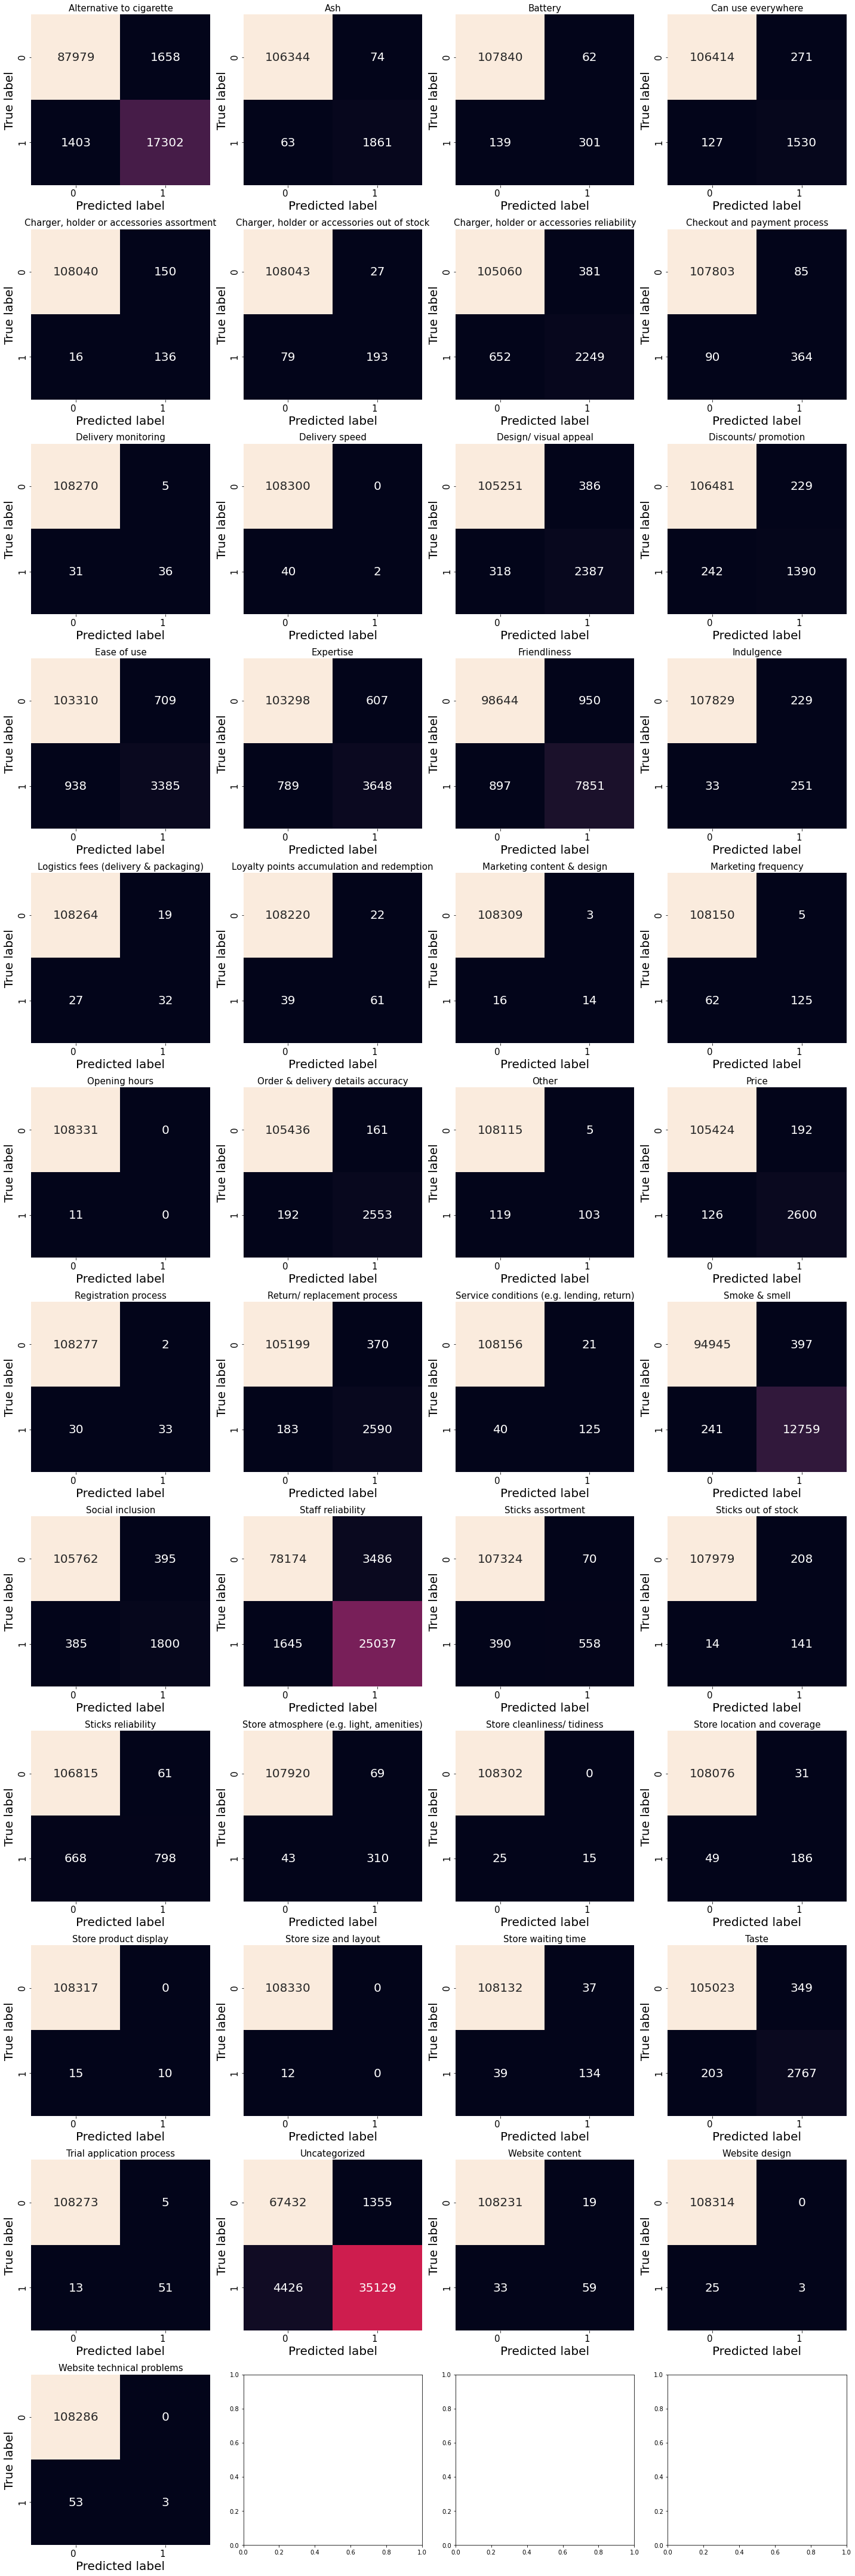

In [48]:
y_train, y_train_preds = get_preds('train', verbose = True)
y_valid, y_valid_preds = get_preds('valid', verbose = True)
y_test, y_test_preds = get_preds('test', verbose = True)

train_acc, train_acc_class, train_hamm, train_f1_score, train_f1_score_class, train_roc_auc, train_roc_auc_class = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True)

valid_acc, valid_acc_class, valid_hamm, valid_f1_score, valid_f1_score_class, valid_roc_auc, valid_roc_auc_class = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True)

test_acc, test_acc_class, test_hamm, test_f1_score, test_f1_score_class, test_roc_auc, test_roc_auc_class = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc, train_f1_score, train_hamm, train_roc_auc))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc, valid_f1_score, valid_hamm, valid_roc_auc))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc, test_f1_score, test_hamm, test_roc_auc))

plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_)

In [49]:
print_classes_error_rate(
    np.concatenate([y_train, y_valid, y_test]), 
    np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
    mlb.classes_,
)

                          Alternative to cigarette   Error rate:  5.652401  TP:17302  FP: 1658  FN: 1403  P:18705
                                               Ash   Error rate: 13.583942  TP: 1861  FP:   74  FN:   63  P: 1924
                                           Battery   Error rate:  1.497512  TP:  301  FP:   62  FN:  139  P:  440
                                Can use everywhere   Error rate:  3.844221  TP: 1530  FP:  271  FN:  127  P: 1657
         Charger, holder or accessories assortment   Error rate:  0.819277  TP:  136  FP:  150  FN:   16  P:  152
       Charger, holder or accessories out of stock   Error rate:  1.820755  TP:  193  FP:   27  FN:   79  P:  272
        Charger, holder or accessories reliability   Error rate:  2.177154  TP: 2249  FP:  381  FN:  652  P: 2901
                      Checkout and payment process   Error rate:  2.080000  TP:  364  FP:   85  FN:   90  P:  454
                               Delivery monitoring   Error rate:  1.000000  TP:   36  FP

Calculating optimal threshold



Train:        Accuracy: 0.00000, F1 score: 0.92684, Hamming Loss: 0.00437, ROC-AUC: 0.99472
Validation:   Accuracy: 0.68834, F1 score: 0.82044, Hamming Loss: 0.01064, ROC-AUC: 0.97017
Test:         Accuracy: 0.68620, F1 score: 0.81531, Hamming Loss: 0.01087, ROC-AUC: 0.96742


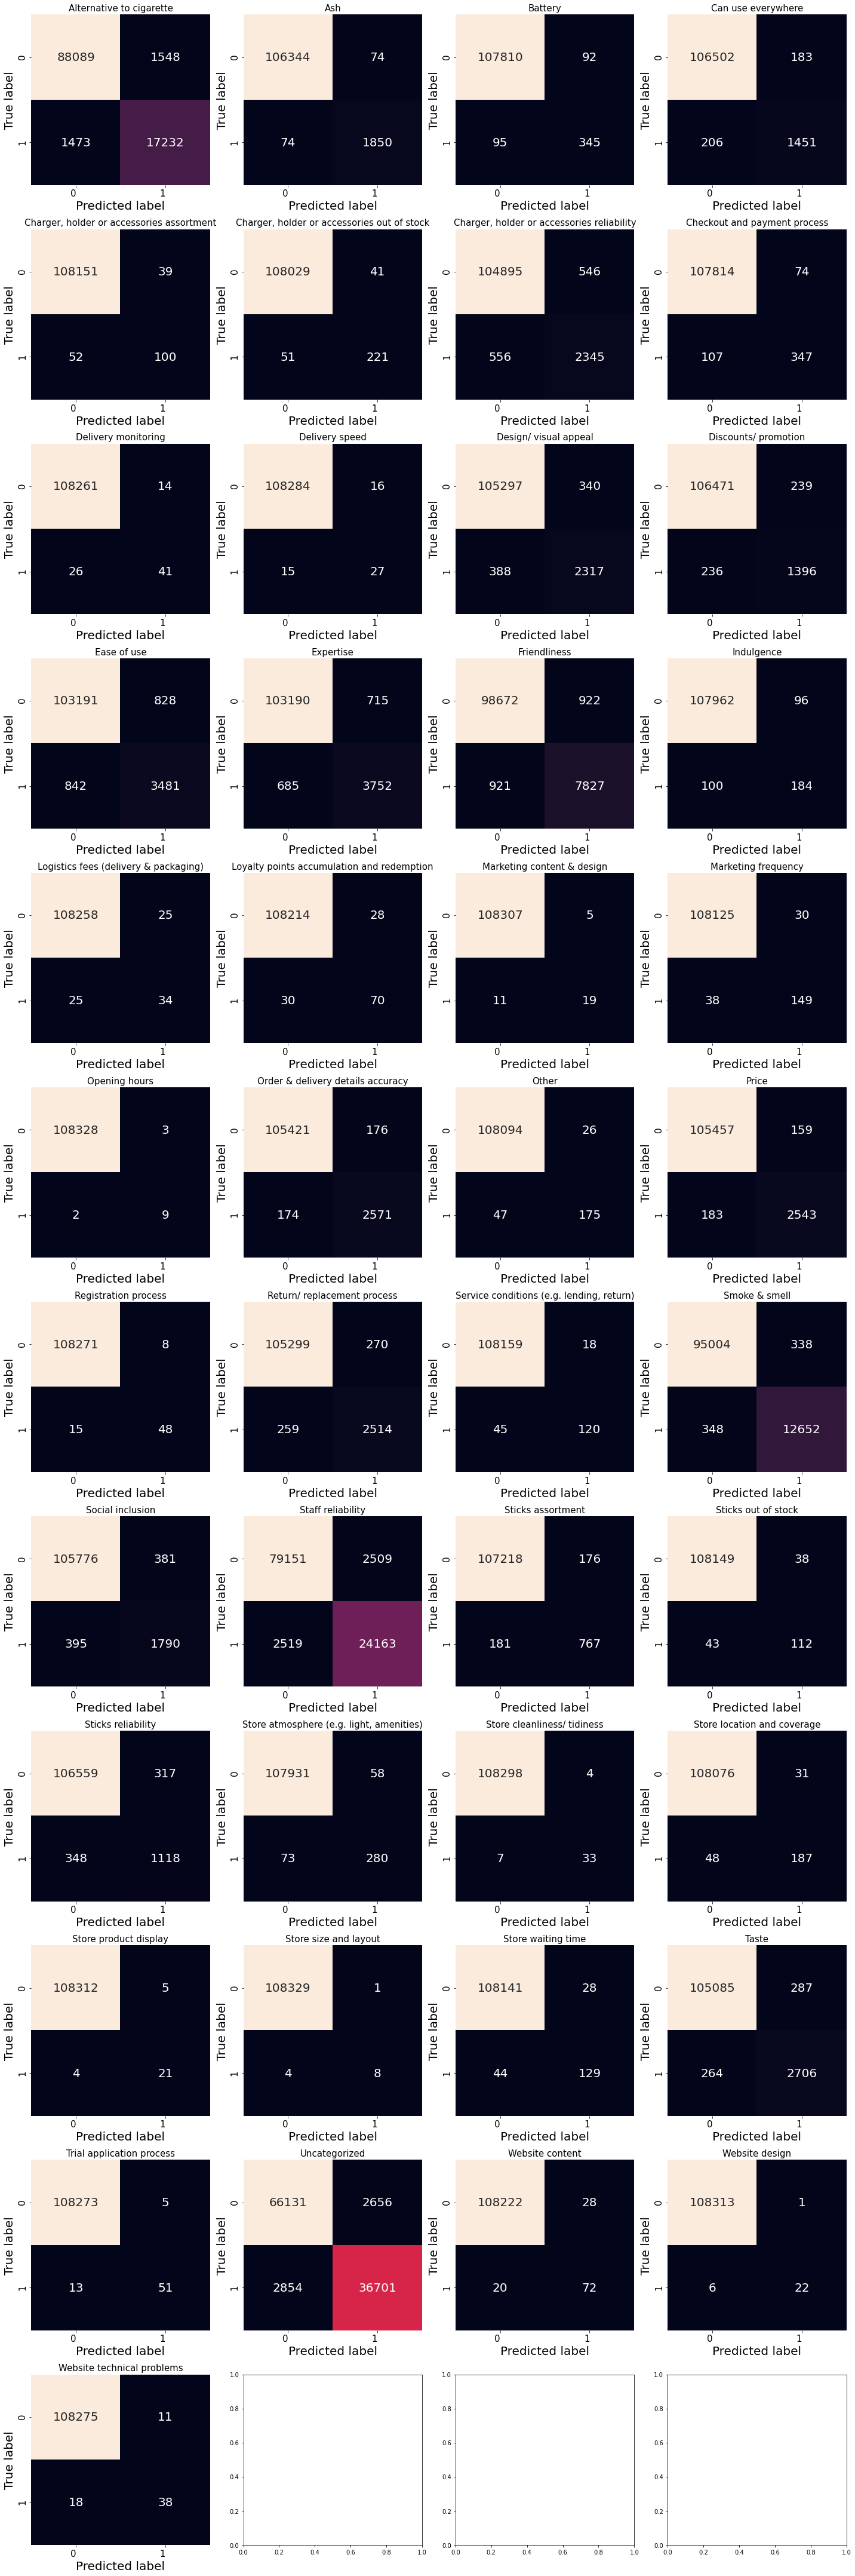

                          Alternative to cigarette   Error rate:  5.704071  TP:17232  FP: 1548  FN: 1473  P:18705
                                               Ash   Error rate: 12.500000  TP: 1850  FP:   74  FN:   74  P: 1924
                                           Battery   Error rate:  1.844920  TP:  345  FP:   92  FN:   95  P:  440
                                Can use everywhere   Error rate:  3.730077  TP: 1451  FP:  183  FN:  206  P: 1657
         Charger, holder or accessories assortment   Error rate:  1.098901  TP:  100  FP:   39  FN:   52  P:  152
       Charger, holder or accessories out of stock   Error rate:  2.402174  TP:  221  FP:   41  FN:   51  P:  272
        Charger, holder or accessories reliability   Error rate:  2.127949  TP: 2345  FP:  546  FN:  556  P: 2901
                      Checkout and payment process   Error rate:  1.917127  TP:  347  FP:   74  FN:  107  P:  454
                               Delivery monitoring   Error rate:  1.025000  TP:   41  FP

In [80]:
ts = optimal_threshold(y_train, y_train_preds, len(mlb.classes_), verbose = True)

train_acc_ts, train_acc_class_ts, train_hamm_ts, train_f1_score_ts, train_f1_score_class_ts, train_roc_auc_ts, train_roc_auc_class_ts = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True, ts = ts)

valid_acc_ts, valid_acc_class_ts, valid_hamm_ts, valid_f1_score_ts, valid_f1_score_class_ts, valid_roc_auc_ts, valid_roc_auc_class_ts = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True, ts = ts)

test_acc_ts, test_acc_class_ts, test_hamm_ts, test_f1_score_ts, test_f1_score_class_ts, test_roc_auc_ts, test_roc_auc_class_ts = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True, ts = ts)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc_ts, train_f1_score_ts, train_hamm_ts, train_roc_auc_ts))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc_ts, valid_f1_score_ts, valid_hamm_ts, valid_roc_auc_ts))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc_ts, test_f1_score_ts, test_hamm_ts, test_roc_auc_ts))

plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_,
        ts = ts)

print_classes_error_rate(
    np.concatenate([y_train, y_valid, y_test]), 
    np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
    mlb.classes_,
    ts = ts
)

In [81]:
bert_classifier.save()

2021-03-03 08:36:21.250 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321Topics/model]


In [82]:
np.save(PATH_SAVE + r'/ts.npy', ts)

In [ ]:
!cp {PATH_RUBERT + '/vocab.txt'} {PATH_SAVE + '/vocab.txt'}